In [1]:
import pandas as pd
# import os
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'nltk'

# Preprocessing

In [18]:
def preprocess(textData):
    preprocessed_texts = []
    preprocessed_tokens = []
    for text in textData:
        # Convert passage to lower case
        cleanTextData = text.lower()
        
        # Tokenize the text
        tokens = word_tokenize(cleanTextData)
        
        # Erase punctuation
        tokens = [token for token in tokens if token not in string.punctuation]
        
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        # update new words to stop dictionary
        stop_words.update(["film", "movie", "watch", "see"])
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        
        # Join the lemmatized tokens back into a single string (document)
        preprocessed_texts.append(' '.join(lemmatized_tokens))
        
        # Extend preprocessed tokens list
        preprocessed_tokens.extend(lemmatized_tokens)
    
    return preprocessed_texts, preprocessed_tokens

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
df = pd.read_csv(".\home_alone_reviews_enhanced.csv", sep = ';')
df.head(5)
df.dtypes

Rating      object
Title       object
Username    object
Date        object
Review      object
dtype: object

In [23]:
textData = df['Review']
preprocessed_texts, preprocessed_tokens = preprocess(textData)
print(preprocessed_tokens)

['see', 'classic', 'many', 'time', 'never', 'cease', 'get', 'old', 'bunch', 'great', 'scenery', 'adorableness', 'original', 'vibe', 'comedy', 'macaulay', 'culkin', 'shin', 'much', 'deserve', 'million', 'earn', 'role', 'love', 'joe', 'pesci', 'go', 'scorsese', 'film', 'swore', 'much', 'bite', 'tongue', 'john', 'hughe', 'gift', 'writer', 'helm', 'gem', '53', '57', 'found', 'helpful', 'review', 'helpful', 'sign', 'vote', 'permalink', 'overwhelm', 'success', "'home", 'alone', 'spawn', 'two', 'sequel', 'enough', 'guarantee', 'people', 'love', 'story', 'family', 'departs', 'paris', 'christmas', 'holiday', 'mistakenly', 'leave', 'eight-year', 'old', 'boy', 'fend', 'fend', 'burglar', 'threaten', 'break', 'unless', 'rig', 'enough', 'booby-traps', 'keep', "'s", 'simple', 'plot', 'nutshell', 'macaulay', 'culkin', 'seem', 'problem', 'carry', 'wide', 'variety', 'look', 'gesture', 'expression', '--', 'money', "'s", 'daniel', 'stern', 'joe', 'pesci', 'get', 'main', 'laugh', 'bumbling', 'burglar', 'in

# Wordcloud

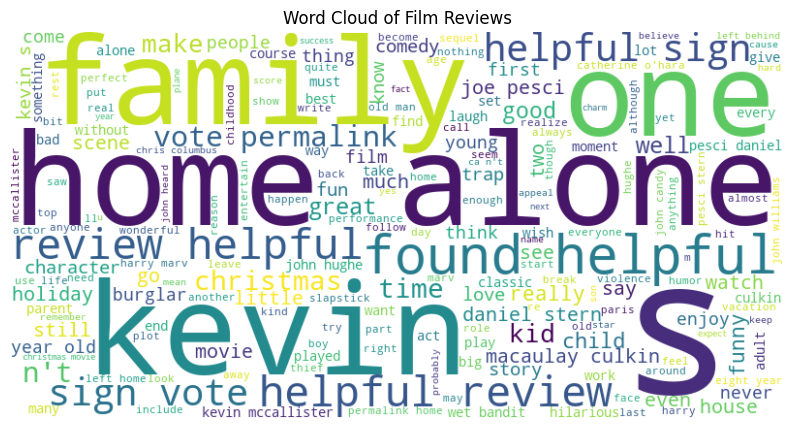

In [26]:
combined_text = ' '.join(preprocessed_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='steelblue').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Film Reviews")
plt.axis('off')
plt.show()

# TF-IDF

In [27]:
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer and transform the preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top feature words
num_top_words = 15
top_feature_indices = tfidf_matrix[0].toarray().argsort()[0][-num_top_words:][::-1]

# Print top feature words with their tf-tdf values
print("Top", num_top_words, "feature words with TF-IDF values:")
for index in top_feature_indices:
    feature_word = feature_names[index]
    tfidf_value = tfidf_matrix[0, index]
    print(f"{feature_word}: {tfidf_value}")

Top 15 feature words with TF-IDF values:
57: 0.21155027672393548
bite: 0.21155027672393548
53: 0.21155027672393548
cease: 0.21155027672393548
earn: 0.21155027672393548
scorsese: 0.21155027672393548
scenery: 0.21155027672393548
tongue: 0.21155027672393548
vibe: 0.21155027672393548
adorableness: 0.21155027672393548
swore: 0.21155027672393548
helm: 0.19494841612204672
gift: 0.19494841612204672
hughe: 0.19494841612204672
much: 0.18640670210208596


# LDA


Top words per topic:

Topic #0:
listen mouth helm 500 aim was disappoint 21 2020 remade

Topic #1:
hot describe them thieve hateful brownie cozy nobody smooth chocolate

Topic #2:
helpful home kevin christmas alone one family review found permalink

Topic #3:
iraq grandmother bought astound russian azerbaijan so language detail 90s

Topic #4:
adore laughting commedy masterpiece blanket snack heaven largely wrap lovely


C:\Users\yuyuyuerh\AppData\Local\Temp\ipykernel_19620\135003346.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[topic_idx].set_yticklabels([feature_names[i] for i in topic.argsort()[-num_top_words:][::-1]])


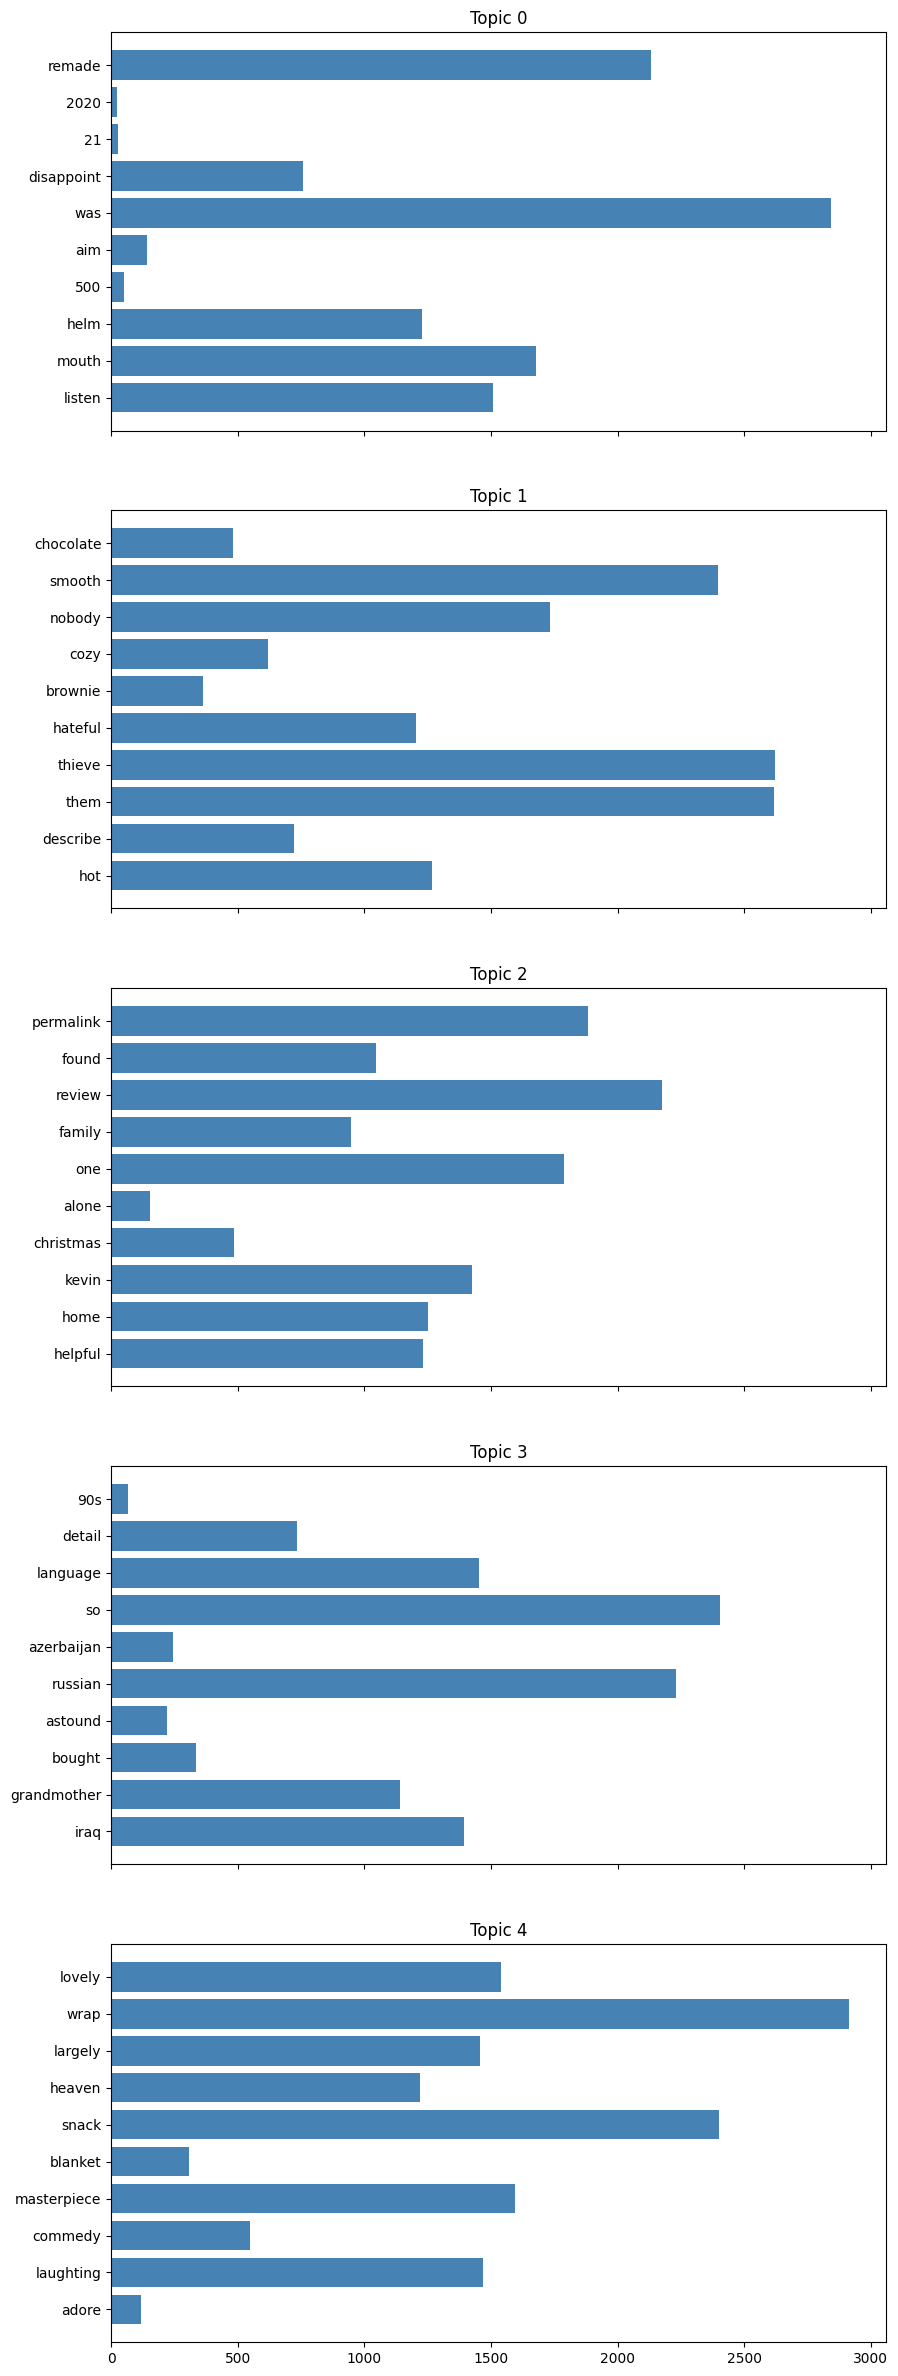

In [34]:
num_topics = 5  # Adjust this as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit LDA model to TF-IDF matrix
lda.fit(tfidf_matrix)

# Function to print top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print top words for each topic
num_top_words = 10  # set the number of topics
print("\nTop words per topic:")
print_top_words(lda, feature_names, num_top_words)

# Visualization
fig, ax = plt.subplots(num_topics, 1, figsize=(10, 6*num_topics), sharex=True)
for topic_idx, topic in enumerate(lda.components_):
    ax[topic_idx].barh([str(i) for i in range(num_top_words)], topic.argsort()[-num_top_words:][::-1], color='steelblue')
    ax[topic_idx].set_yticklabels([feature_names[i] for i in topic.argsort()[-num_top_words:][::-1]])
    ax[topic_idx].set_title('Topic {}'.format(topic_idx))
plt.show()
